# Natural Language Intent to Parameterized Function Calls with Phi-3

This notebook explores mapping natural language intent to parameterized function calls with small language models (SLM). This is 
particularly relevant in edge scenarios where latency and/or connectivity issues make the unavailability of cloud-only solutions infeasible.

To make the scenario more concrete, this evaluation considers a use case that has a lot of traction in the automotive industry: 
an an automotive assistant that helps a driver control non-safety critical systems.  It also focuses the investigation around Phi-3 SLM,
but also consider other SLMs (in particular Llama3) and different sizes of Phi-3 (in particular small and medium) to compare and contrast
the baseline performance of Phi-3 mini with these other SLMs.

Finally, it also considers three different implementation techniques.  Namely, it considers:

1. Llama.cpp (via python wrappers / CUDA accelerated) with direct prompts of the LLM.
2. Llama.cpp (via python wrappers / CUDA accelerated) with guidance managed LLM generation.
2. Ollama HTTP endpoint hosted SLMs with direct prompt usage of the LLM to see if there is a performance benefit.
    
There are three main questions this experiment sought to answer:

1. Can Phi-3 accurately map user natural language intents to parameterized function calls? And how does it compare to other SLMs?
2. Can it achieve this with the low latency required for a fluent user experience?
3. How do different backend hosting and implementation techniques affect latency and correctness?

The performance results for this investigation were captured in an WSL2 Ubuntu environment on an AMD 7950X3D desktop PC 
with an Nvidia RTX4080 GPU.  All configurations were configured to use the GPU for acceleration.

This investigation shows that:

1) Yes, this is feasible with the simple single intent commands we consider here. Phi-3 mini is able to map intent to the 
   correct function with the correct parameters at least 95% of the time with 0% incorrect function (but valid function call) mappings
   that cause the most user confusion.
2) With GPU acceleration, it is possible for Phi-3 to do this mapping in P99 subsecond time.
3) Implementation matters a great deal. This investigation shows that utilizing LLM steering libraries like guidance can 
   both greatly accelerate performance (3.1x to 14.2x) and greatly improve successful outcomes (89% -> 99%).

Finally, there are many avenues where this work could be extended:

1. Extending the investigation to look at more complex natural language commands like "Please lower the temperature to 59 and increase the fan" to investigate if SLMs can decode these multiple intents into multiple function calls.
2. How do SLMs perform with the typical recognition errors of a speech to text system?

In [25]:
import json

with open('results/model-eval-amd-7950x3d-rtx4080.json', 'r') as file:
    data = json.load(file)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

records = []
for model, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'model': model,
            'tool': tool,
            'pass_percentage': metrics['pass_percentage'],
            'median_latency': metrics['median_latency'],
            'latencies': metrics['latencies'],
            'errors': metrics['errors']
        })

df = pd.DataFrame(records)

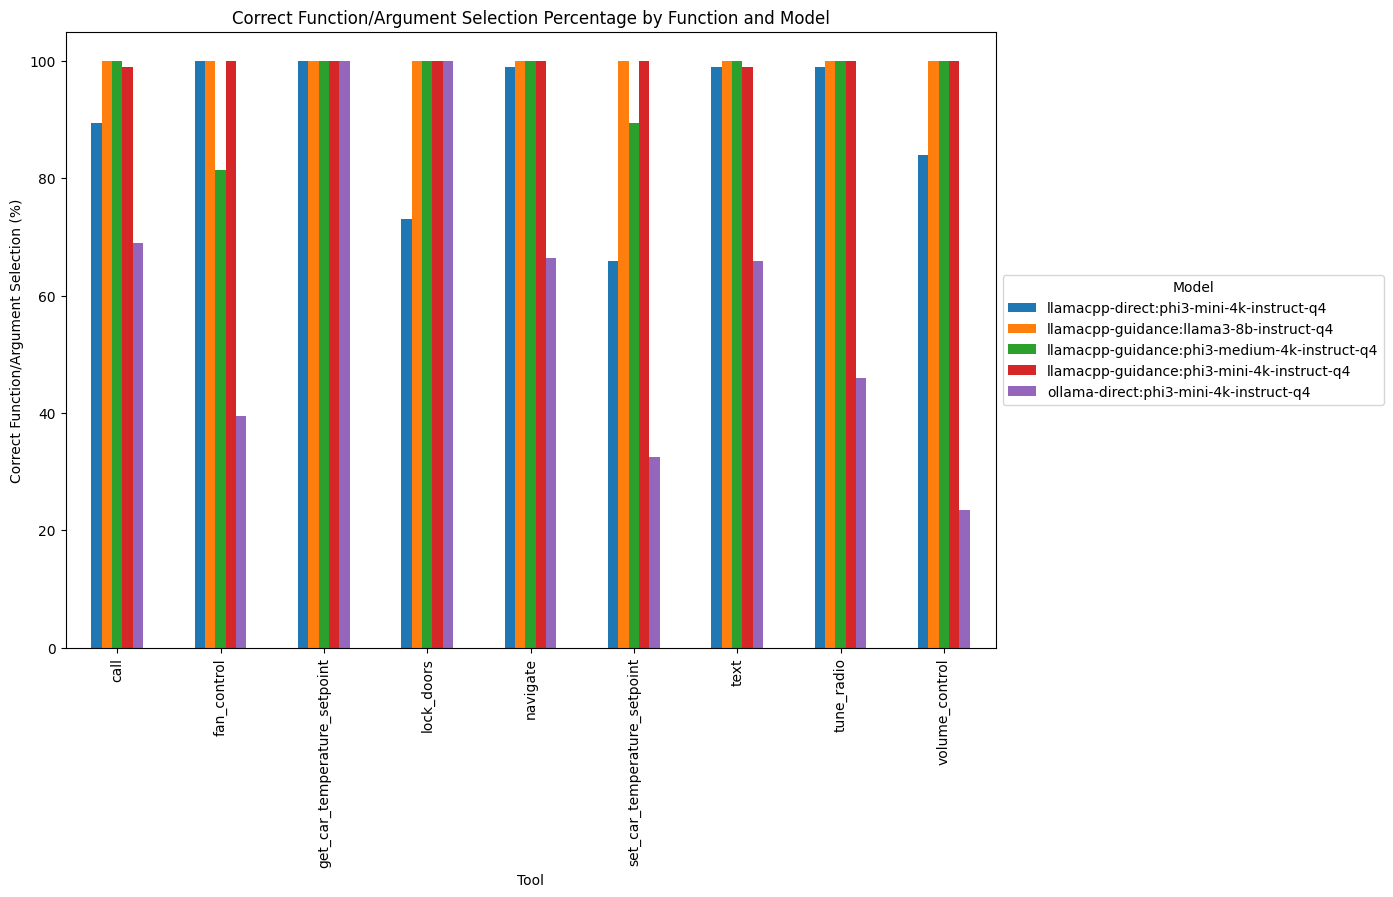

In [27]:

# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Function/Argument Selection Percentage by Function and Model')
plt.xlabel('Tool')
plt.ylabel('Correct Function/Argument Selection (%)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [42]:
from tabulate import tabulate
from IPython.display import display, HTML

def print_results(results):
    headers = ["f(x)", "p", "fi", "pi", "nfr", "i(bvfc)", "total", "%", "min (ms)", "mean", "median", "max (ms)"]

    data = []
    total_count = 0
    passed_count = 0
    total_median_latency = 0.0
    tool_count = 0

    for pivot in results:
        tool_count += 1
        pivot_results = results[pivot]
        if pivot_results["total_evaluations"] > 0:
            passed = pivot_results["passed"]
            function_incorrect = pivot_results["function_incorrect"]
            parameters_incorrect = pivot_results["parameters_incorrect"]
            non_function_response = pivot_results["non_function_response"]
            total_evaluations = pivot_results["total_evaluations"]
            incorrect_but_valid = pivot_results["incorrect_but_valid"]
            pass_percentage = pivot_results["pass_percentage"]

            passed_count += passed
            total_count += total_evaluations
            total_median_latency += pivot_results["median_latency"]

            min_latency = pivot_results["min_latency"]
            max_latency = pivot_results["max_latency"]
            mean_latency = pivot_results["mean_latency"]
            median_latency = pivot_results["median_latency"]

            data.append([pivot, passed, function_incorrect, parameters_incorrect, non_function_response, incorrect_but_valid, total_evaluations, pass_percentage, min_latency, mean_latency, median_latency, max_latency])  

    print(tabulate(data, headers=headers))

    overall_percentage = 100.0 * passed_count / total_count
    overall_median_latency = total_median_latency / tool_count

    print()
    print(f"overall: {passed_count} / {total_count} ({overall_percentage:.2f}%) {overall_median_latency:.2f}ms avg median latency")
    
for config_tag in data:
    display(HTML(f"<b>{config_tag}</b>"))
    print()
    print_results(data[config_tag])
    print()


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)     mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  -------  --------  ----------
call                          198     0     2      0          0      200   99    215.754   376.753   353.757     704.668
fan_control                   200     0     0      0          0      200  100    150.614   185.637   184.549     215.381
get_car_temperature_setpoint  200     0     0      0          0      200  100     79.8361  135.213   133.393     179.081
lock_doors                    200     0     0      0          0      200  100    156.612   218.581   219.32      255.665
navigate                      200     0     0      0          0      200  100    441.006   887.158   880.177    1264.88
set_car_temperature_setpoint  200     0     0      0          0      200  100    439.761   479.183   474.749     543.458
text                          19


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100       928.231  1431.77   1369.33     2440.83
fan_control                   163    37     0      0         37      200   81.5     415.235   863.515   871.721    1031.64
get_car_temperature_setpoint  200     0     0      0          0      200  100       614.797   741.179   730.729     971.722
lock_doors                    200     0     0      0          0      200  100       438.286   971.445   979.04     1104.85
navigate                      200     0     0      0          0      200  100      1667.52   2828.76   2828.83     3850.51
set_car_temperature_setpoint  179     0    21      0          0      200   89.5    1721.3    1933.83   1944.59     2208.56
text        


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100     670.562   914.912   873.798    1465.11
fan_control                   200     0     0      0          0      200  100     535.753   652.082   641.244     771.195
get_car_temperature_setpoint  200     0     0      0          0      200  100     352.217   465.269   441.793     600.97
lock_doors                    200     0     0      0          0      200  100     521.106   672.389   658.972     838.063
navigate                      200     0     0      0          0      200  100     943.738  1510.9    1500.79     2229.92
set_car_temperature_setpoint  200     0     0      0          0      200  100     947.431  1044.38   1032.12     1254.81
text                       


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          179     0    21      0          0      200   89.5     782.557   1484.08   927.652     3066.27
fan_control                   200     0     0      0          0      200  100      1326.55    1923.33  2183.07      2329.94
get_car_temperature_setpoint  200     0     0      0          0      200  100      1395.37    1890.85  1930         2247.58
lock_doors                    146     0     0     54          0      200   73       982.909   1982.79  1494.78      2915.83
navigate                      198     0     1      1          0      200   99      1120.25    1566.8   1543.95      3708.45
set_car_temperature_setpoint  132     0     0     68          0      200   66      1484.95    2057.7   1525.58     11766.3
text    


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          138     0    62      0          0      200   69       431.414  1010.34   1052.32      1559.47
fan_control                    79     0   121      0          0      200   39.5     709.932  1239.1    1147.34     12987.7
get_car_temperature_setpoint  200     0     0      0          0      200  100       469.437   868.345   928.303     1080.34
lock_doors                    200     0     0      0          0      200  100       463.379   951.971   949.392     1223.4
navigate                      133     0    67      0          0      200   66.5     638.693  1232.6    1236.18      1474.62
set_car_temperature_setpoint   65     0   134      1          0      200   32.5     681.153  1229.14   1219.57      2467.64
text     

This evaluation tested two different implementation approaches. The first was the direct prompting of the LLM via llama.cpp's python bindings and the second was to use llama.cpp in conjunction with the [guidance](https://github.com/guidance-ai/guidance) steering library. Guidance allows you to guide the LLM, specifying "must have" boilerplate in the response, specific options for portions of the response, and regular expressions for acceptable characters in other portions of the response. This both essentially steers the LLM towards valid responses and also accelerates generation, as the LLM does not need to generate the boilerplate portions but instead has those tokens pushed directly into its context.  In the context of function calling, where the goal is to return a JSON document with the function and the parameters, this approach is particularly effective, as the results above show.

For phi3-mini-4k-instruct-q4, the difference between the directly prompting and guidance steered approach boosted correct function mapping from (89.94% to 99.77%) and reduced mean latency from (3258ms to 423ms, -75.42% decrease).

The evaluation also tested four different models: phi3-mini-4k-instruct-q4, phi3-medium-4k-instruct-q4, llama3-8b-instruct-q4, and gemma-2b-instruct-q8. Llama3-8b-instruct-q4 was the most correct (100%) but also at twice the parameters (resulting in higher GPU requirements, so higher cost) and at a higher latency (951ms vs. 419ms, 127% higher).

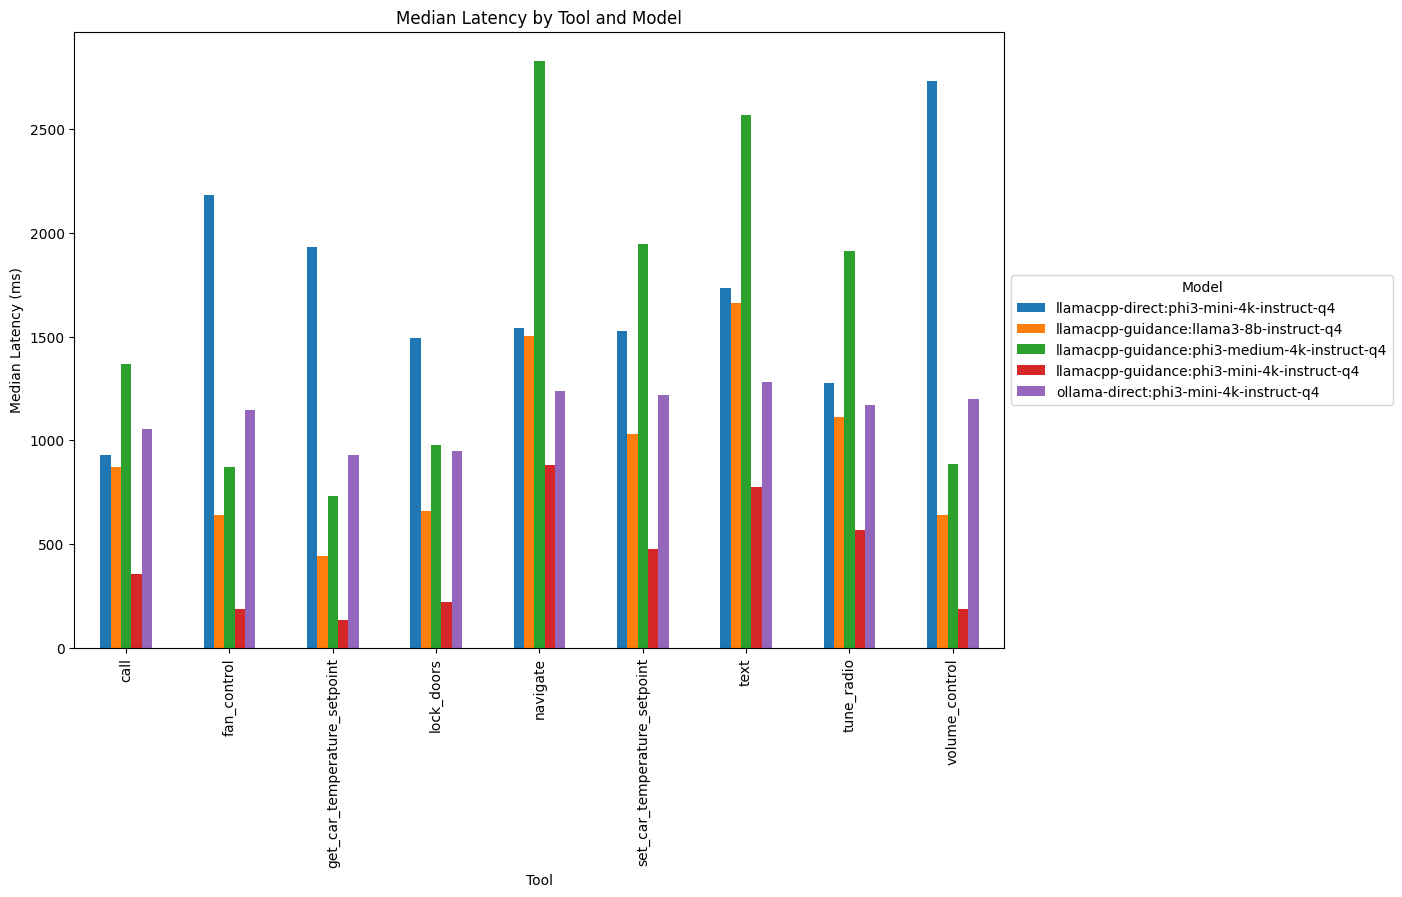

In [30]:
# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool and Model')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

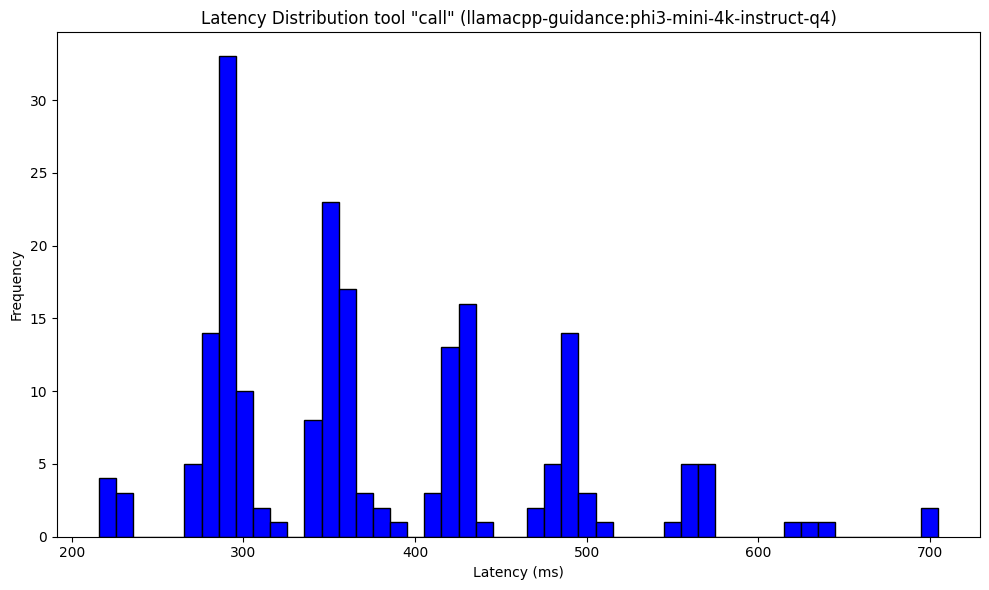

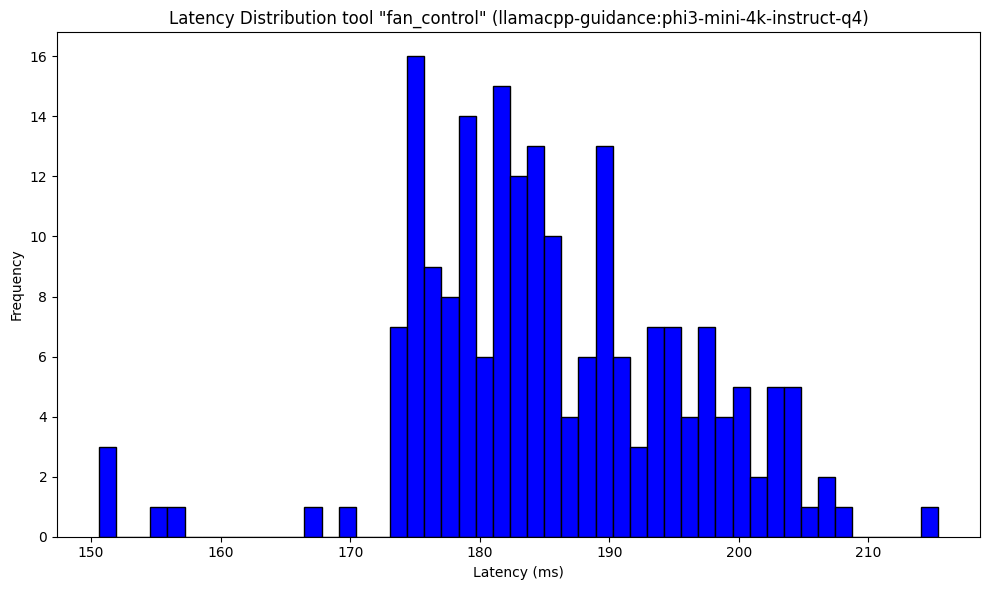

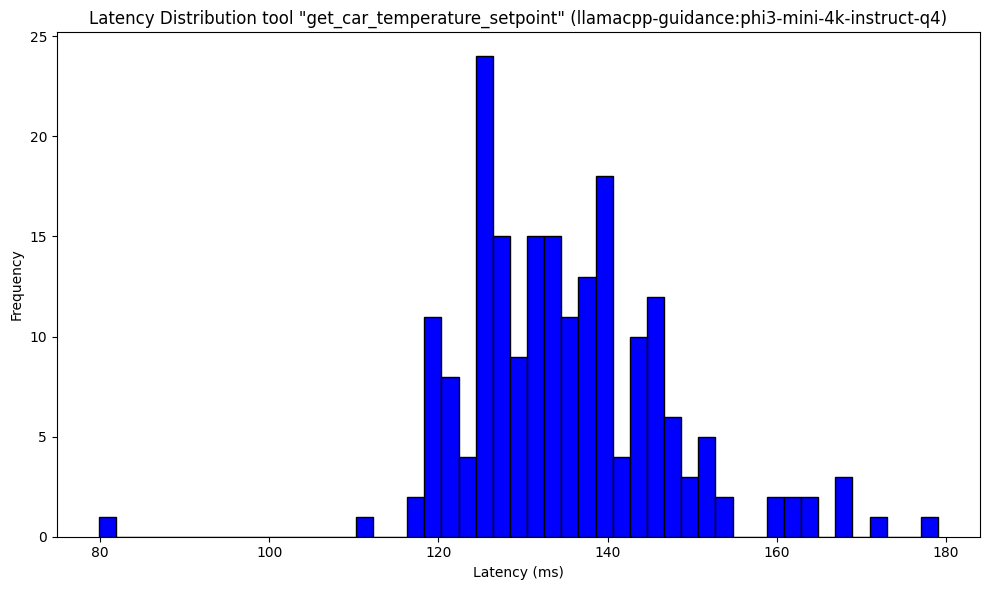

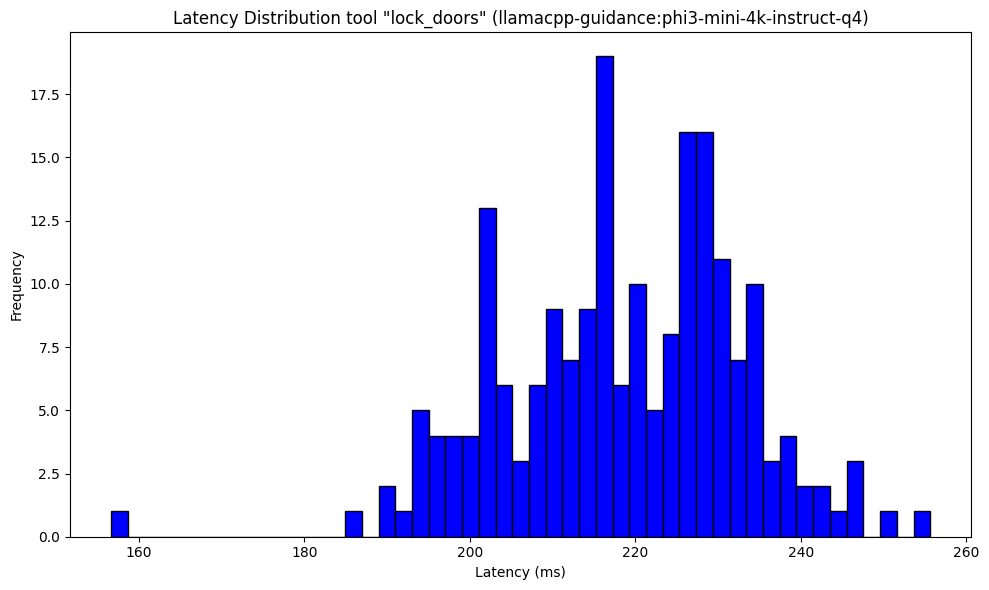

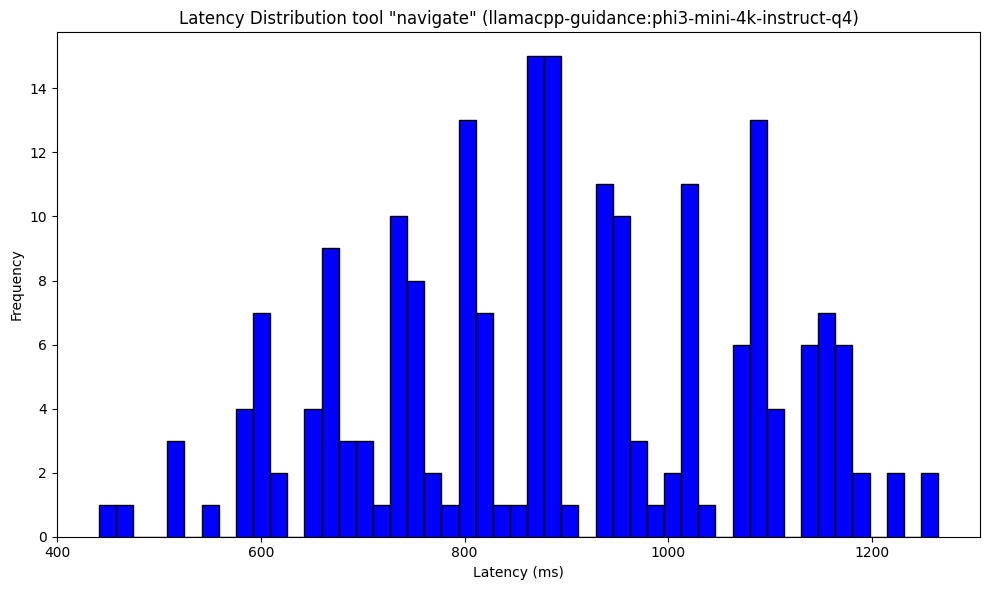

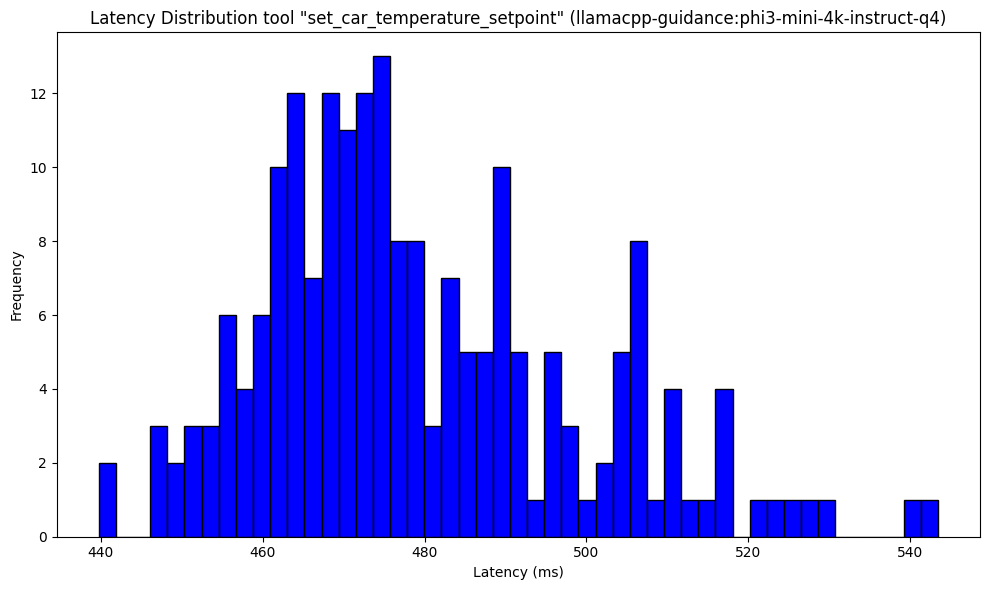

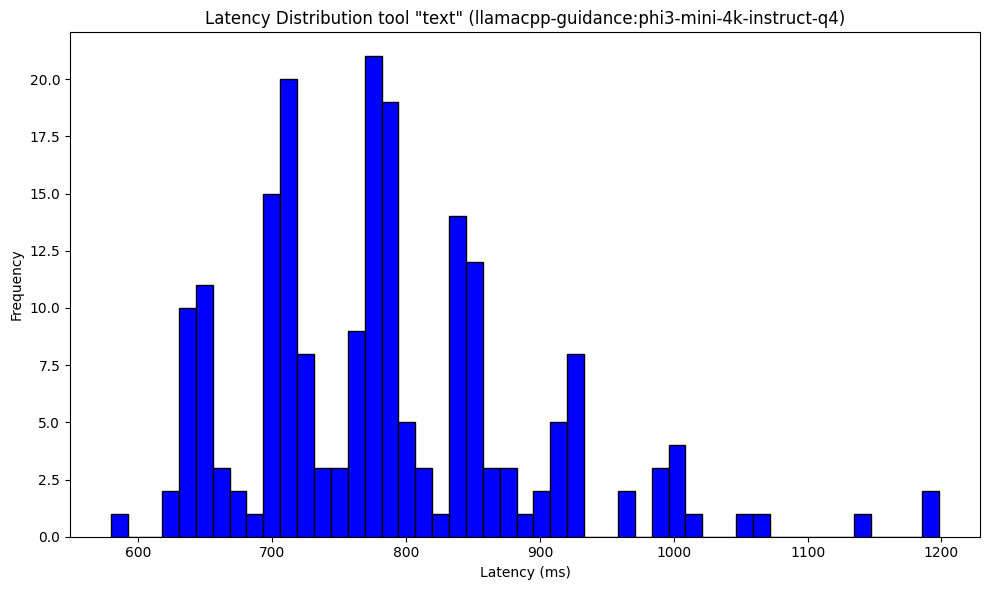

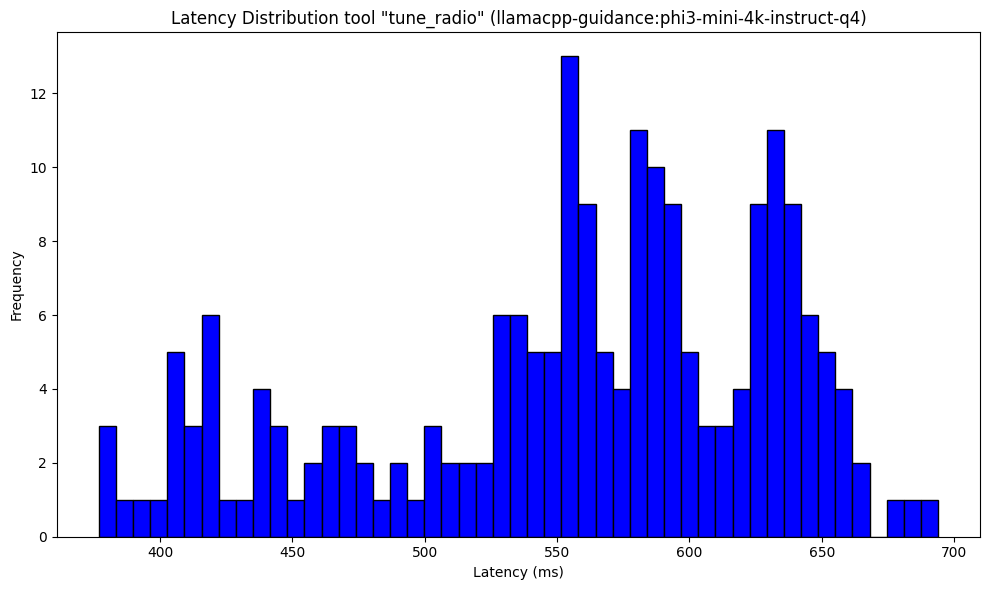

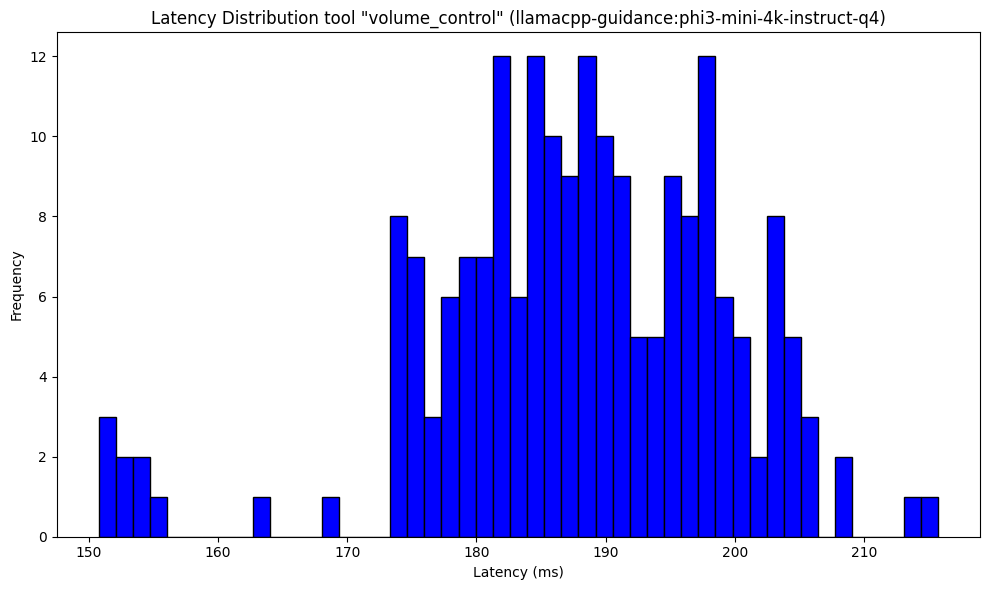

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots are displayed inline
%matplotlib inline

llamacpp_guidance_df = df[df['model'].apply(lambda model: model == "llamacpp-guidance:phi3-mini-4k-instruct-q4")]

for row in llamacpp_guidance_df.iterrows():
    config_name = row[1]['model']
    tool_name = row[1]['tool']
    latencies = row[1]['latencies']

    # Create bins for the histogram
    min_latency = min(latencies)
    max_latency = max(latencies)
    bins = np.linspace(min_latency, max_latency, 50)
    
    # Plotting the latency distribution
    plt.figure(figsize=(10, 6))
    plt.hist(latencies, bins=bins, edgecolor='black', color='blue')
    
    plt.title(f'Latency Distribution tool "{tool_name}" ({config_name})')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Frequency')

    # Adjust layout to ensure no overlapping elements
    plt.tight_layout()
    
    plt.show()

In [33]:
from IPython.display import display, HTML

errors_df = df[df['errors'].apply(lambda x: len(x) > 0)]
headers = ["user", "exp f(x)", "gen f(x)", "exp params", "gen params"]

for index, row in errors_df.iterrows():
    model_name = row['model']
    tool_name = row['tool']
    errors = row['errors']

    display(HTML(f"<b>Errors analysis for {tool_name} with config {model_name}</b>"))
    
    errors_table = []
    for error in errors:
        print()
        user_input = error["user_input"]
        
        expected_function = error["expected_function"]
        generated_function = error["generated_function"]
        
        if expected_function != generated_function:
            print(f"{user_input} -> expected f(x) {expected_function} vs. generated {generated_function}")

        expected_parameters = error["expected_parameters"]
        generated_parameters = error["generated_parameters"]
        
        if expected_parameters != generated_parameters:
            print(f'"{user_input}"')
            print(f"expected params:  {expected_parameters}")
            print(f"generated params: {generated_parameters}")

    print()
        


"Please call Clara Müller"
expected params:  {'name': 'Clara Müller'}
generated params: {'name': 'Clara Muller'}

"Please call Steven Ramirez"
expected params:  {'name': 'Steven Ramirez'}
generated params: {'name': 'Steven Ramiree'}




"Please text Marta Fernández that I am running late for dinner"
expected params:  {'name': 'Marta Fernández', 'message': 'I am running late for dinner'}
generated params: {'name': 'Marta Fernandez', 'message': 'I am running late for dinner'}

"Please text Manuel Pérez that I am running late"
expected params:  {'name': 'Manuel Pérez', 'message': 'I am running late'}
generated params: {'name': 'Manuel Perez', 'message': 'I am running late.'}




Decrease fan speed -> expected f(x) fan_control vs. generated volume_control
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'volume': 'decrease'}

Decrease fan speed -> expected f(x) fan_control vs. generated volume_control
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'volume': 'decrease'}

Decrease fan speed -> expected f(x) fan_control vs. generated volume_control
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'volume': 'decrease'}

Decrease fan speed -> expected f(x) fan_control vs. generated volume_control
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'volume': 'decrease'}

Decrease fan speed -> expected f(x) fan_control vs. generated volume_control
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'volume': 'decrease'}

Decrease fan speed -> expected f(x) fan_control vs. generated volume_control
"Decrease fan speed"
e


"Please change it to 68 degrees for me."
expected params:  {'temperature': 68}
generated params: {'temperature': 680.0}

"Can you adjust it to 69 degrees?"
expected params:  {'temperature': 69}
generated params: {'temperature': 690.0}

"I’d like the temperature at 64 degrees, please."
expected params:  {'temperature': 64}
generated params: {'temperature': 640.0}

"Could you please change it to 69 degrees?"
expected params:  {'temperature': 69}
generated params: {'temperature': 690.0}

"Can you make it 69 degrees?"
expected params:  {'temperature': 69}
generated params: {'temperature': 690.0}

"Can you make it 68 degrees?"
expected params:  {'temperature': 68}
generated params: {'temperature': 680.0}

"Can you adjust it to 62 degrees?"
expected params:  {'temperature': 62}
generated params: {'temperature': 620.0}

"Set it at 74 degrees, thanks."
expected params:  {'temperature': 74}
generated params: {'temperature': 740.0}

"Could you change the temp to 64 degrees?"
expected params:  {


"Please call James Garcia"
expected params:  {'name': 'James Garcia'}
generated params: [{'name': 'name', 'value': 'James Garcia'}]

"Please call Elena"
expected params:  {'name': 'Elena'}
generated params: [{'name': 'name', 'value': 'Elena'}]

"Please call Jeremy Barnes"
expected params:  {'name': 'Jeremy Barnes'}
generated params: [{'name': 'name', 'value': 'Jeremy Barnes'}]

"Please call Hans"
expected params:  {'name': 'Hans'}
generated params: [{'name': 'name', 'value': 'Hans'}]

"Please call Christopher Fisher"
expected params:  {'name': 'Christopher Fisher'}
generated params: [{'name': 'name', 'value': 'Christopher Fisher'}]

"Please call Rachel Walker"
expected params:  {'name': 'Rachel Walker'}
generated params: [{'name': 'name', 'value': 'Rachel Walker'}]

"Please call Louise Dubois"
expected params:  {'name': 'Louise Dubois'}
generated params: [{'name': 'name', 'value': 'Louise Dubois'}]

"Please call Clara"
expected params:  {'name': 'Clara'}
generated params: [{'name': 'n


"Get directions to 60 Nevsky Prospect"
expected params:  {'destination': '60 Nevsky Prospect'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '60 Nevsky Prospect'}]




"Please text Marta Fernández that I am running late for dinner"
expected params:  {'name': 'Marta Fernández', 'message': 'I am running late for dinner'}
generated params: {'name': 'Marta Fernandez', 'type': 'string', 'message': 'I am running late for dinner'}

"Please text Manuel Pérez that I am running late"
expected params:  {'name': 'Manuel Pérez', 'message': 'I am running late'}
generated params: {'name': 'Manuel Perez', 'message': 'I am running late'}




"Change the radio to KQED"
expected params:  {'station': 'KQED'}
generated params: [{'name': 'station', 'type': 'string', 'value': 'KQED'}]




"Please call Manuel Pérez"
expected params:  {'name': 'Manuel Pérez'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Manuel Pérez'}]

"Please call Anders"
expected params:  {'name': 'Anders'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Anders'}]

"Please call Kimberly Ward"
expected params:  {'name': 'Kimberly Ward'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Kimberly Ward'}]

"Please call Magnus Nilsson"
expected params:  {'name': 'Magnus Nilsson'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Magnus Nilsson'}]

"Please call Laura Horváth"
expected params:  {'name': 'Laura Horváth'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Laura Horváth'}]

"Please call Lisa"
expected params:  {'name': 'Lisa'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Lisa'}]

"Please call Renata"
expected params:  {'name': 'Renata'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'R


"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['off', 'low', 'medium', 'max']}]

"Increase the fan please"
expected params:  {'level': 'increase'}
generated params: [{'name': 'increase', 'type': 'string'}]

"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['full']}]

"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: [{'name': 'decrease'}]

"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: [{'name': 'decrease', 'type': 'string'}]

"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['off', 'low', 'medium', 'max', 'increase', 'decrease']}]

"Turn off fan"
expected para


"Get directions to 1600 Holloway Avenue"
expected params:  {'destination': '1600 Holloway Avenue'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '1600 Holloway Avenue'}]

"Take me to 30 Via del Corso, Rome"
expected params:  {'destination': '30 Via del Corso, Rome'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '30 Via del Corso, Rome'}]

"Take me to 90 Andrássy Avenue"
expected params:  {'destination': '90 Andrássy Avenue'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '90 Andrássy Avenue'}]

"Take me to 1500 Sugar Bowl Drive, New Orleans, Louisiana"
expected params:  {'destination': '1500 Sugar Bowl Drive, New Orleans, Louisiana'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '1500 Sugar Bowl Drive, New Orleans, Louisiana'}]

"Get directions to 60 Nevsky Prospect, Saint Petersburg"
expected params:  {'destination': '60 Nevsky Prospect, Saint Petersburg'}
generated params: [{'name': 'desti


"Could you change the temp to 75 degrees?"
expected params:  {'temperature': 75}
generated params: [{'name': 'temperature', 'type': 'float', 'value': 75.0}]

"Please change it to 68 degrees for me."
expected params:  {'temperature': 68}
generated params: [{'name': 'temperature', 'type': 'float', 'value': 68}]

"Can you change the temperature to 61 degrees?"
expected params:  {'temperature': 61}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Can you set it to 68 degrees?"
expected params:  {'temperature': 68}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Adjust the temperature to 72 degrees, please."
expected params:  {'temperature': 72}
generated params: [{'name': 'temperature', 'type': 'float', 'value': 72.0}]

"Can you set it to 63 degrees?"
expected params:  {'temperature': 63}
generated params: [{'name': 'temperature', 'type': 'float', 'value': 63.0}]

"Can you please set it to 73 degrees?"
expected params:  {'temperature': 73}
generated params: [{


"Please text Oliver Klein that I am running late"
expected params:  {'name': 'Oliver Klein', 'message': 'I am running late'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Oliver Klein'}, {'name_type': 'string', 'value': 'I am running late'}]

"Please text Maria Petrova that I am running late for dinner"
expected params:  {'name': 'Maria Petrova', 'message': 'I am running late for dinner'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Maria Petrova'}, {'name': 'message', 'type': 'string', 'value': 'I am running late for dinner'}]

"Please text Marta Fernández that I am running late for dinner"
expected params:  {'name': 'Marta Fernández', 'message': 'I am running late for dinner'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Marta Fernández'}, {'name type': 'string', 'value': 'I am running late for dinner'}]

"Please text Maria Rossi that I am on my way"
expected params:  {'name': 'Maria Rossi', 'message': 'I am on my way'}
generat


"Change the radio to 90.3"
expected params:  {'station': 90.3}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['90.1 FM', '90.2 FM', '90.3 FM', '90.4 FM']}]

"Could you adjust the radio to 100.3 for me?"
expected params:  {'station': 100.3}
generated params: [{'name': 'station', 'type': 'string'}]

"Please tune to Radio Bob on the radio"
expected params:  {'station': 'Radio Bob'}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['107.5FM', '98.3FM', 'Radio Bob FM']}]

"Could you adjust the radio to The Beach for me?"
expected params:  {'station': 'The Beach'}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['The Beach']}]

"Could you adjust the radio to BBC Radio 1 for me?"
expected params:  {'station': 'BBC Radio 1'}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['BBC Radio 1']}]

"Can you switch the radio to 98.5?"
expected params:  {'station': 98.5}
generated params: [{'nam


"Please make it louder"
expected params:  {'volume': 'increase'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['increase']}]

"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Please make it louder"
expected params:  {'volume': 'increase'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['increase']}]

"Mute audio"
expected params:  {'volume': 'mute'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['mute']}]

"Can you raise the volume?"
expected params:  {'volume': 'increase'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['increase']}]

"Please lower the volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Please lower the volume"
expected params:  {'volume': 'decrease'}
generated params: [{'

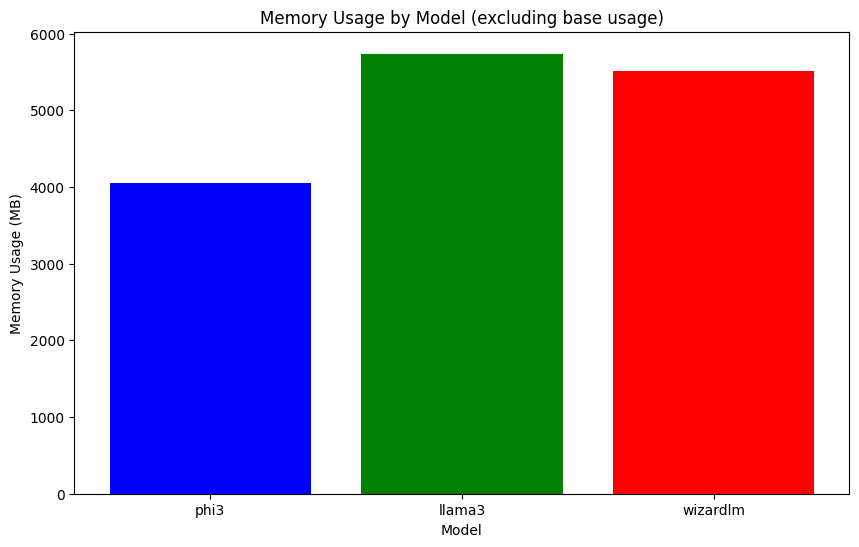

In [13]:
# Base memory usage
base_memory_usage = 1889 # MB

# Compute gross memory measurements with nvidia-smi minus base usage
phi3_memory_usage = 5935 - base_memory_usage # MB
llama3_memory_usage = 7626 - base_memory_usage # MB
wizardlm_memory_usage = 7403 - base_memory_usage # MB

# Data for plotting
models = ['phi3', 'llama3', 'wizardlm']
memory_usage = [phi3_memory_usage, llama3_memory_usage, wizardlm_memory_usage]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage, color=['blue', 'green', 'red'])

plt.title('Memory Usage by Model (excluding base usage)')
plt.xlabel('Model')
plt.ylabel('Memory Usage (MB)')
plt.show()

In [14]:
with open('results/tool-count-eval-m1-max.json', 'r') as file:
    data = json.load(file)

In [15]:
records = []

for tool_count, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'tool_count': tool_count,
            'tool': tool,
            'median_latency': metrics['median_latency'],
            'pass_percentage': metrics['pass_percentage'],
        })

df = pd.DataFrame(records)

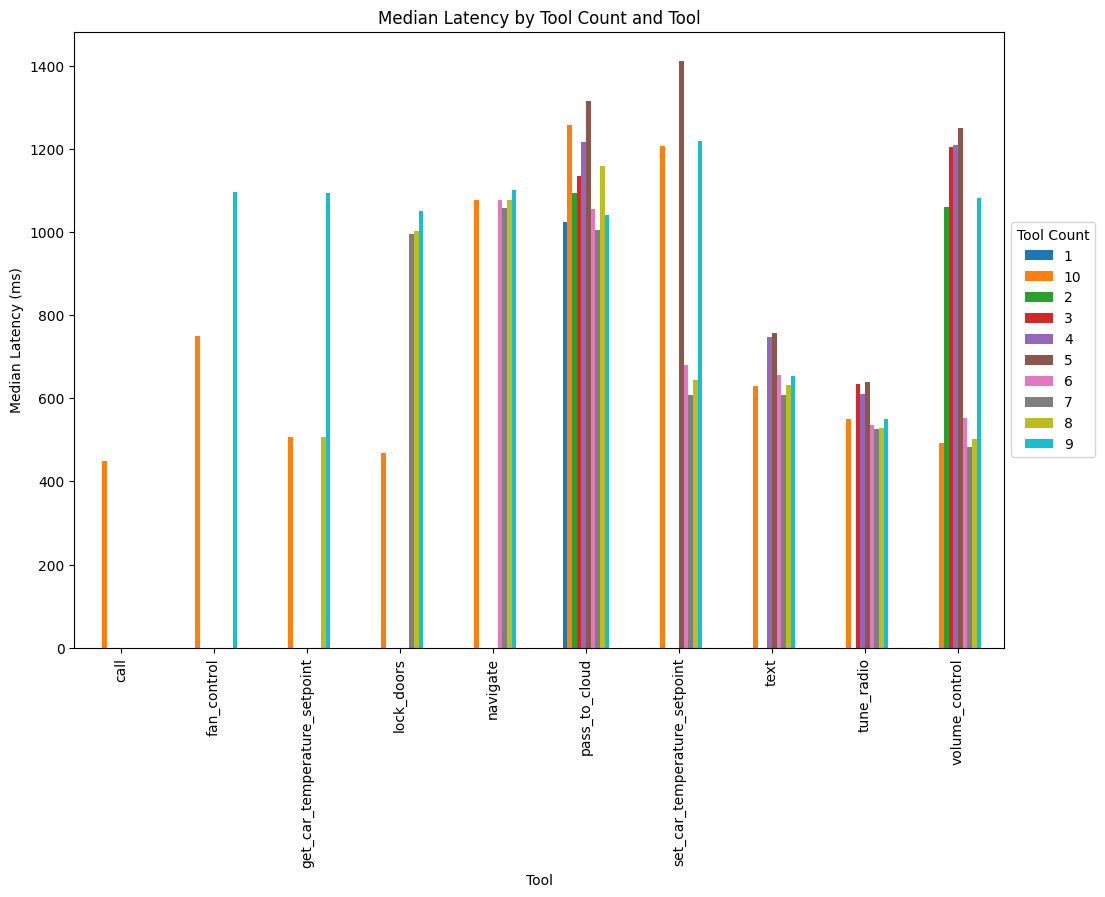

In [16]:
# Pivot the DataFrame to have tool counts as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='tool_count', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

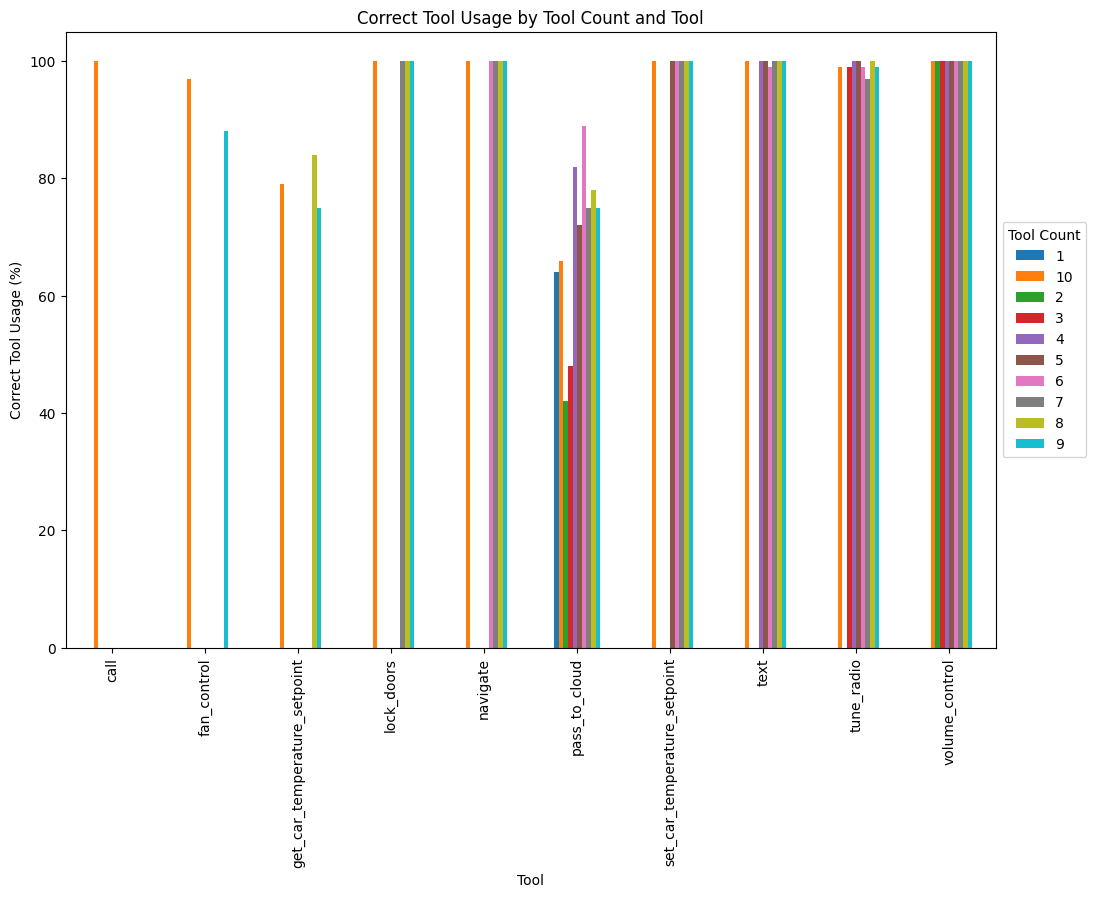

In [17]:
pivot_df = df.pivot(index='tool', columns='tool_count', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Tool Usage by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Correct Tool Usage (%)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

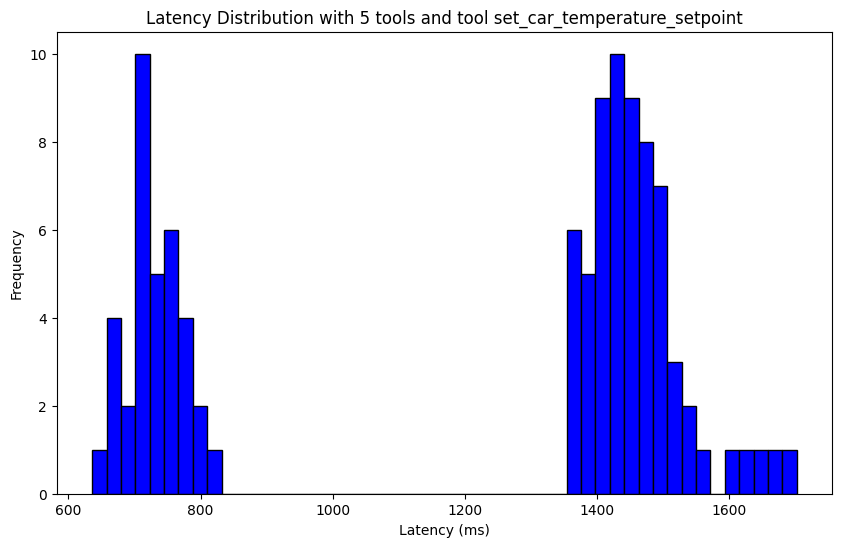

In [18]:
import numpy as np
import matplotlib.pyplot as plt

tool_count = '5'
tool_name = 'set_car_temperature_setpoint'

five_tool_count = data[tool_count]
latencies = five_tool_count[tool_name]['latencies']

# Create bins for the histogram
min_latency = min(latencies)
max_latency = max(latencies)
bins = np.linspace(min_latency, max_latency, 50)

# Plotting the latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=bins, edgecolor='black', color='blue')

plt.title(f'Latency Distribution with {tool_count} tools and tool {tool_name}')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Are there user inputs that are more likely to fail?
# How does hardware effect latency (4800 vs. M1 Max vs M4)?